# Exercise 1: E-commerce Data Pipeline Challenge

**Difficulty**: Advanced  
**Time**: 45-60 minutes  
**Skills**: Complex merging, aggregations, feature engineering

## Business Context

You're working on an ML model to predict customer lifetime value for an e-commerce platform. You need to create features from transactional data spanning multiple tables.

## The Challenge

Given three datasets:

1. **transactions**: Customer purchases over time
2. **customers**: Customer demographic information
3. **products**: Product catalog with categories

Create a customer-level feature matrix for ML training.

## Data Description

### Transactions Table

```python
# transactions.csv - 100k+ rows
columns = ['transaction_id', 'customer_id', 'product_id', 'quantity',
           'price', 'discount', 'timestamp', 'payment_method']
```

### Customers Table

```python
# customers.csv
columns = ['customer_id', 'registration_date', 'age', 'country',
           'email_domain', 'acquisition_channel']
```

### Products Table

```python
# products.csv
columns = ['product_id', 'category', 'subcategory', 'brand',
           'base_price', 'margin']
```

## Requirements

### Part 1: Data Quality Assessment (10 min)

1. Identify and handle missing values across all tables
2. Detect and resolve duplicate transactions
3. Find outliers in transaction amounts
4. Validate data consistency (e.g., negative quantities)

### Part 2: Feature Engineering (25 min)

Create these customer-level features:

1. **Behavioral features**:

   - Total transactions, revenue, items purchased
   - Average order value, frequency
   - Days since last purchase
   - Purchase velocity (transactions per week)

2. **Product affinity features**:

   - Number of unique categories purchased
   - Favorite category (by spend)
   - Brand loyalty score

3. **Time-based features**:
   - Seasonality patterns (quarterly spend)
   - Recency, Frequency, Monetary (RFM) scores
   - Purchase acceleration/deceleration

### Part 3: Advanced Aggregations (15 min)

1. Calculate rolling 30-day metrics
2. Create customer segments based on purchase patterns
3. Compute cross-category purchase probabilities

### Part 4: ML Pipeline Extension (Optional - 15 min)

If time permits, extend your feature matrix for machine learning:

1. **Target variable creation**:

   - Define a business metric to predict (e.g., customer lifetime value bucket, churn risk)
   - Handle class imbalance if present

2. **ML-ready features**:

   - Create interaction features (e.g., AOV × frequency)
   - Ratio features (profit margin, items per transaction)
   - Behavioral indicators (high-value customer flags)

3. **Quick model validation**:
   - Train/test split with proper stratification
   - Fit a simple baseline model (logistic regression or random forest)
   - Evaluate with appropriate metrics

## Key Discussion Points

- How would you handle memory constraints with larger datasets?
- What data quality issues concern you most?
- How would you make this pipeline production-ready?
- What additional features might improve the model?
- **ML Extension**: How would you validate this model in production?
- **ML Extension**: What metrics would you monitor for model drift?

## Success Criteria

- Clean, readable code with proper error handling
- Efficient pandas operations (vectorized when possible)
- Thoughtful feature engineering with business rationale
- Discussion of scalability considerations
- **ML Extension**: Proper train/test methodology without data leakage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [2]:
cust = pd.read_csv('datasets/exercise_01/customers.csv')
transa = pd.read_csv('datasets/exercise_01/transactions.csv')
prods = pd.read_csv('datasets/exercise_01/products.csv')

In [11]:
cust

,customer_id,registration_date,age,country,email_domain,acquisition_channel
0,CUST_000001,2023-03-24,41.0,DE,yahoo.com,organic
1,CUST_000002,2025-05-05,NaN,US,hotmail.com,organic
2,CUST_000003,2023-05-18,52.0,US,gmail.com,organic
3,CUST_000004,2023-09-01,53.0,US,startup.io,partnerships
4,CUST_000005,2023-04-22,48.0,FR,gmail.com,organic
...,...,...,...,...,...,...
4995,CUST_004996,2023-10-26,50.0,US,company.com,b2b
4996,CUST_004997,2024-01-02,28.0,BR,startup.io,partnerships
4997,CUST_004998,2025-04-18,51.0,DE,university.edu,education
4998,CUST_004999,2025-07-01,27.0,JP,company.com,b2b


In [15]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          5000 non-null   object 
 1   registration_date    5000 non-null   object 
 2   age                  4846 non-null   float64
 3   country              4943 non-null   object 
 4   email_domain         5000 non-null   object 
 5   acquisition_channel  5000 non-null   object 
dtypes: float64(1), object(5)
memory usage: 234.5+ KB


In [17]:
transa

,transaction_id,customer_id,product_id,quantity,price,discount,timestamp,payment_method
0,TXN_00000001,CUST_003986,PROD_000922,1,18.76,3.36,2024-07-23 10:34:28,paypal
1,TXN_00000002,CUST_001193,PROD_000548,1,142.95,33.16,2024-04-24 02:01:28,debit_card
2,TXN_00000003,CUST_000043,PROD_000046,1,23.22,3.56,2024-03-11 19:28:28,bank_transfer
3,TXN_00000004,CUST_000363,PROD_000513,2,11.56,0.00,2024-12-19 10:30:28,paypal
4,TXN_00000005,CUST_004498,PROD_000891,1,867.86,0.00,2024-01-11 03:10:28,paypal
...,...,...,...,...,...,...,...,...
49995,TXN_00049996,CUST_002368,PROD_000842,3,14.46,0.00,2023-08-26 01:06:05,bank_transfer
49996,TXN_00049997,CUST_002864,PROD_000298,1,16.34,2.33,2023-09-11 22:05:05,credit_card
49997,TXN_00049998,CUST_002781,PROD_000854,1,36.52,0.00,2023-09-01 16:30:05,credit_card
49998,TXN_00049999,CUST_003020,PROD_000347,2,54.77,6.16,2023-11-14 23:01:05,debit_card


In [18]:
transa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  50000 non-null  object 
 1   customer_id     50000 non-null  object 
 2   product_id      50000 non-null  object 
 3   quantity        50000 non-null  int64  
 4   price           50000 non-null  float64
 5   discount        50000 non-null  float64
 6   timestamp       50000 non-null  object 
 7   payment_method  49027 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.1+ MB


array([[<Axes: title={'center': 'quantity'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'discount'}>, <Axes: >]], dtype=object)

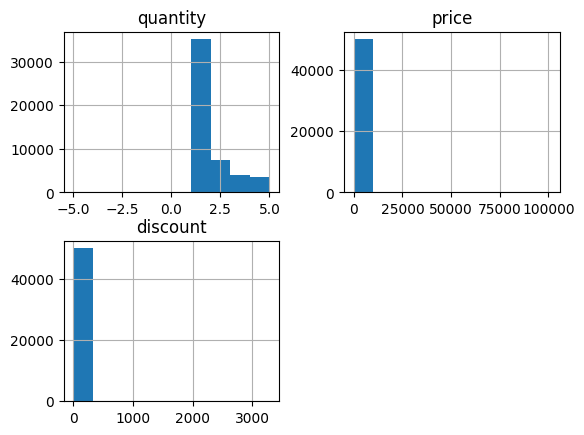

In [21]:
transa.hist()